<a href="https://colab.research.google.com/github/kunakl07/Killer-Whale-sound-classification/blob/master/Stage2_Template_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/axiom-data-science/OrcaCNN-data

Cloning into 'OrcaCNN-data'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 68 (delta 3), reused 61 (delta 2), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [0]:
cd /content/OrcaCNN-data

/content/OrcaCNN-data


In [0]:
rm /content/OrcaCNN-data/data/training/positive/class_labels.json

In [0]:

import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm

DATA_PATH = "/content/OrcaCNN-data/data/training/"


# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc


def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)


def get_train_test(split_ratio=0.6, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)



def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            # Downsampling
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(wave, sr=16000)
            vectors.append(mfcc)

        data[label]['mfcc'] = vectors

    return data


def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]


# print(prepare_dataset(DATA_PATH))



Using TensorFlow backend.


In [0]:



import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 100
batch_size = 100
verbose = 1
num_classes = 2

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)


Saving vectors of label - 'negative': 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


In [0]:
!pip install pydub
from pydub import AudioSegment

AUDIO_FILE="/content/OrcaCNN-data/data/long_samples/long_sample_01.wav"
sound = AudioSegment.from_file(AUDIO_FILE)
i=0
k=0
p=0
m=len(sound)
halfway_point = 4000
for i in range(i,m,4000):

        first_half = sound[p:halfway_point]
     #   sh=sound[p+4000:halfway_point+4000]


        k=k+4000
        first_half.export("/content/OrcaCNN-data/data/long_sample{0}.wav".format(k),format="wav")
    #    sh.export("/content/Pests-data/popo{0}.wav".format(k),format="wav")
        halfway_point=halfway_point+4000
        p=p+4000

44100


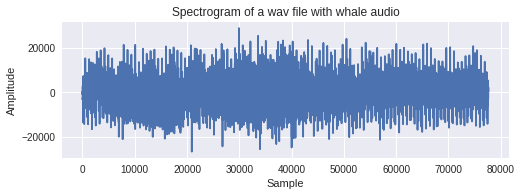

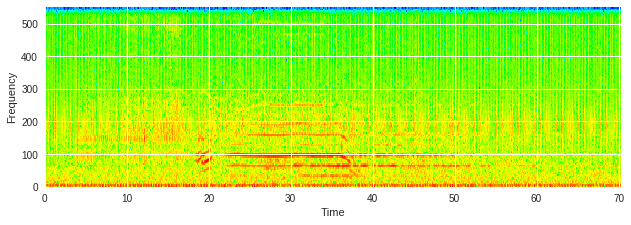

In [0]:
import matplotlib.pyplot as plot

from scipy.io import wavfile

 

samplingFrequency, signalData = wavfile.read('/content/OrcaCNN-data/data/training/positive/03.wav')
print(samplingFrequency)






plot.subplot(211)

plot.title('Spectrogram of a wav file with whale audio')

 

plot.plot(signalData)

plot.xlabel('Sample')

plot.ylabel('Amplitude')


fig,ax = plot.subplots(1)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax.axis('tight')
ax.axis('off')

plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency/40, cmap='hsv_r')

plot.xlabel('Time')

plot.ylabel('Frequency')

#fig.savefig('pos_wav00.png')
#fig,ax = plot.subplots(1)
#fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
#ax.axis('off')
#pxx, freqs, bins, im = ax.specgram(x=signalData, Fs=rate, noverlap=384, NFFT=512)
#ax.axis('off')
fig.savefig('positive03.png', dpi=300, frameon='false')
 

plot.show()




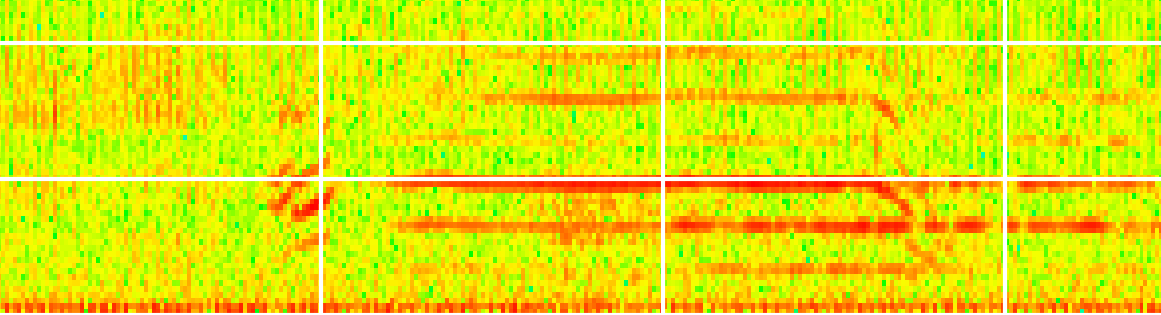

In [0]:
from IPython.display import Image
import cv2
Image(filename='/content/positive03_template.png')


Min_val= -0.16318118572235107  Max_val= 0.982922375202179


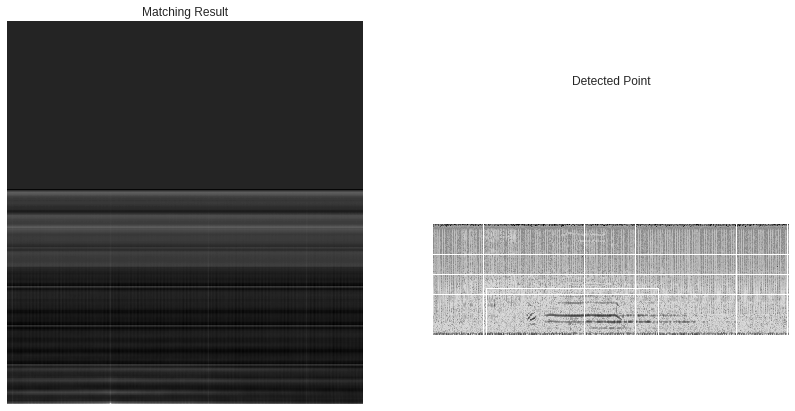

In [0]:
def match_template(template_to_match, image_where_to_search):
    # Read the images
    img = cv2.imread(image_where_to_search,0)
    img2 = img.copy()
    template = cv2.imread(template_to_match,0)
    w, h = template.shape[::-1]

    # Set method 
    meth = 'cv2.TM_CCOEFF_NORMED'
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    # Obtain vals and locs (max_lox corresponds to the best match)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    print ('Min_val=', min_val, ' Max_val=', max_val)
    # Add rectangle with match
    bottom_right = (max_loc[0] + w, max_loc[1] + h)
    cv2.rectangle(img,max_loc, bottom_right, 255, 3)

    # Plot matching and image with best match in rectangle
    plot.figure(figsize = (14,8))
    plot.subplot(121),plot.imshow(res,cmap = 'gray', interpolation='nearest')
    plot.title('Matching Result'), plot.xticks([]), plot.yticks([])
    plot.subplot(122),plot.imshow(img, cmap = 'gray', interpolation='nearest')
    plot.title('Detected Point'), plot.xticks([]), plot.yticks([])
    plot.show()

match_template('/content/positive03_template.png', '/content/OrcaCNN-data/positive03.png')


Here we found that the template is matched.

44100


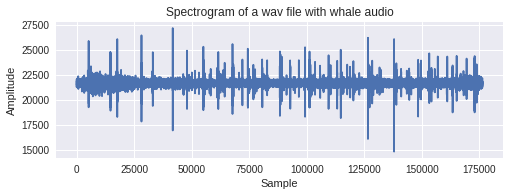

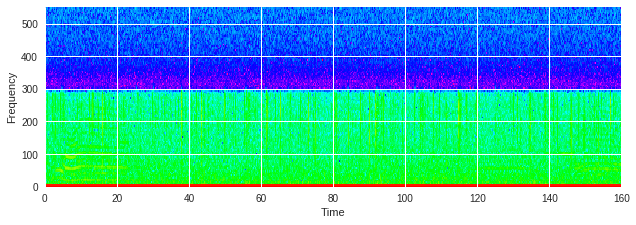

In [0]:
import matplotlib.pyplot as plot

from scipy.io import wavfile

 

samplingFrequency, signalData = wavfile.read('/content/OrcaCNN-data/data/long_sample12000.wav')
print(samplingFrequency)






plot.subplot(211)

plot.title('Spectrogram of a wav file with whale audio')

 

plot.plot(signalData)

plot.xlabel('Sample')

plot.ylabel('Amplitude')


fig,ax = plot.subplots(1)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax.axis('tight')
ax.axis('off')

plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency/40, cmap='hsv_r')

plot.xlabel('Time')

plot.ylabel('Frequency')

#fig.savefig('pos_wav00.png')
#fig,ax = plot.subplots(1)
#fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
#ax.axis('off')
#pxx, freqs, bins, im = ax.specgram(x=signalData, Fs=rate, noverlap=384, NFFT=512)
#ax.axis('off')
fig.savefig('long12.png', dpi=300, frameon='false')
 

plot.show()




Min_val= -0.21034587919712067  Max_val= 0.41176891326904297


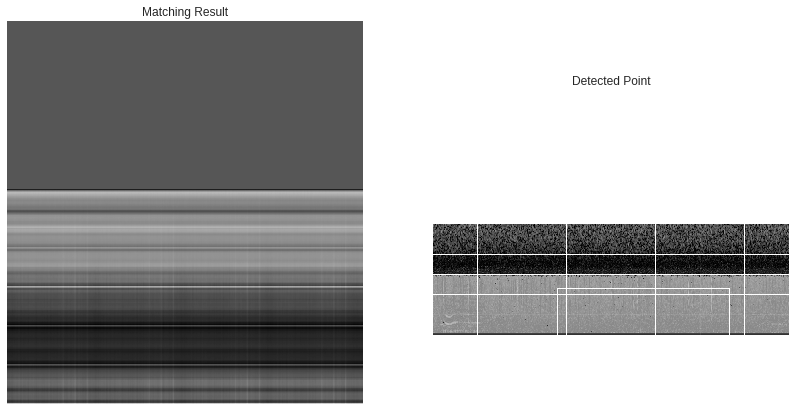

In [0]:
def match_template(template_to_match, image_where_to_search):
    # Read the images
    img = cv2.imread(image_where_to_search,0)
    img2 = img.copy()
    template = cv2.imread(template_to_match,0)
    w, h = template.shape[::-1]

    # Set method 
    meth = 'cv2.TM_CCOEFF_NORMED'
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    # Obtain vals and locs (max_lox corresponds to the best match)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    print ('Min_val=', min_val, ' Max_val=', max_val)
    # Add rectangle with match
    bottom_right = (max_loc[0] + w, max_loc[1] + h)
    cv2.rectangle(img,max_loc, bottom_right, 255, 3)

    # Plot matching and image with best match in rectangle
    plot.figure(figsize = (14,8))
    plot.subplot(121),plot.imshow(res,cmap = 'gray', interpolation='nearest')
    plot.title('Matching Result'), plot.xticks([]), plot.yticks([])
    plot.subplot(122),plot.imshow(img, cmap = 'gray', interpolation='nearest')
    plot.title('Detected Point'), plot.xticks([]), plot.yticks([])
    plot.show()

match_template('/content/positive03_template.png', '/content/OrcaCNN-data/long12.png')


Here, we have matched the positive** training sample** with the long sample and the call is detected which is shown by drawing a box around the call

So,we can confirm the calls in that the long samples(divided into standard length chunks) are present by template matching it with training data